In [2]:
import pandas as pd
import json
import os
import ast

# Define Paths
v33_path = 'v33_Dome-Recommendations-With_Provenance_Verified.tsv'
# Using the specified JSON as template structure
template_path = 'dome_review_raw_human_20260204.json'

# Load Dataset
df_v33 = pd.read_csv(v33_path, sep='\t')
print(f"Loaded {len(df_v33)} rows from {v33_path}")

# Load Template - it is a list of objects, we take the first one as schema
with open(template_path, 'r') as f:
    template_data = json.load(f)
    if isinstance(template_data, list) and len(template_data) > 0:
        template_item = template_data[0]
    else:
        template_item = template_data

# Use the keys from the template as target keys
target_keys = list(template_item.keys())
print("Template keys loaded from first item in dome_review_raw_human_20260204.json:", target_keys)

Loaded 258 rows from v33_Dome-Recommendations-With_Provenance_Verified.tsv
Template keys loaded from first item in dome_review_raw_human_20260204.json: ['_id', 'dataset', 'evaluation', 'model', 'optimization', 'user', 'publication', 'public', 'created', 'updated', 'uuid', 'reviewState', 'shortid', 'update', '__v', 'score']


In [3]:
def transform_row_to_json(row, template):
    new_entry = {}
    
    # Helper to clean value
    def clean_val(val):
        if pd.isna(val):
            return "" 
        return str(val)

    # Helper to handle numbers
    def clean_int(val):
        if pd.isna(val):
            return 0 # Default for numeric fields in schema seems to be int or 0 if missing
        try:
            return int(float(val)) # float cast just in case "1.0"
        except:
            return 0

    # Helper to handle booleans
    def clean_bool(val):
        if pd.isna(val):
            return False
        if isinstance(val, bool):
             return val
        if str(val).lower() in ['true', '1', '1.0', 'yes']:
            return True
        return False
    
    # Iterate through keys in template
    for key, template_val in template.items():
        
        # 1. _id
        if key == '_id':
            # TSV has _id/$oid
            oid_val = row.get('_id/$oid')
            if pd.notna(oid_val):
                new_entry['_id'] = {"$oid": str(oid_val)}
            else:
                 # If missing in TSV, maybe generate or leave empty? 
                 # Generating empty for now as strictly structure mapping
                new_entry['_id'] = {"$oid": ""}
        
        # 2. user
        elif key == 'user':
             # TSV has user/$oid
            oid_val = row.get('user/$oid')
            if pd.notna(oid_val):
                new_entry['user'] = {"$oid": str(oid_val)}
            else:
                new_entry['user'] = {"$oid": ""}

        # 3. created / updated (Date objects)
        elif key == 'created':
            date_val = row.get('created/$date')
            if pd.notna(date_val):
                 new_entry['created'] = {"$date": str(date_val)}
            else:
                 new_entry['created'] = {"$date": ""}
        
        elif key == 'updated':
            date_val = row.get('updated/$date')
            if pd.notna(date_val):
                 new_entry['updated'] = {"$date": str(date_val)}
            else:
                 new_entry['updated'] = {"$date": ""}

        # 4. Nested objects
        elif isinstance(template_val, dict) and key not in ['_id', 'user', 'created', 'updated']:
            new_entry[key] = {}
            # Iterate subkeys of the template object
            for sub_key in template_val.keys():
                tsv_col = f"{key}/{sub_key}"
                val = row.get(tsv_col)
                
                # Check target type based on template value
                target_val_type = type(template_val[sub_key])
                
                # Special handling for known schema types if template is empty
                if sub_key == 'pmid': # Usually int or string? In JSON example it is "32344344" (string)
                     new_entry[key][sub_key] = clean_val(val)
                elif sub_key == 'tags': # List
                     if pd.isna(val) or val == "":
                         new_entry[key][sub_key] = []
                     else:
                         # Attempt to parse list string or split
                         try:
                             parsed = ast.literal_eval(str(val))
                             if isinstance(parsed, list):
                                 new_entry[key][sub_key] = parsed
                             else:
                                 new_entry[key][sub_key] = [str(val)]
                         except:
                             new_entry[key][sub_key] = [str(val)]
                elif isinstance(template_val[sub_key], int):
                    new_entry[key][sub_key] = clean_int(val)
                elif isinstance(template_val[sub_key], bool):
                    new_entry[key][sub_key] = clean_bool(val)
                else:
                    new_entry[key][sub_key] = clean_val(val)

        # 5. Simple fields
        else:
            val = row.get(key)
            # Check target type
            if isinstance(template_val, bool):
                 new_entry[key] = clean_bool(val)
            elif isinstance(template_val, int):
                 new_entry[key] = clean_int(val)
            elif isinstance(template_val, list):
                 new_entry[key] = [] # Assuming simple empty list if not present
            else:
                 new_entry[key] = clean_val(val)

    return new_entry

# Perform transformation
new_json_data = []

count = 0 
for idx, row in df_v33.iterrows():
    entry = transform_row_to_json(row, template_item)
    new_json_data.append(entry)
    count += 1

print(f"Transformed {len(new_json_data)} entries.")

# Save the result
output_filename = 'v33_Dome-Recommendations-With_Provenance_reformatted.json'
with open(output_filename, 'w') as f:
    json.dump(new_json_data, f, indent=4)

print(f"\nSaved reformatted JSON to {output_filename}")

Transformed 258 entries.

Saved reformatted JSON to v33_Dome-Recommendations-With_Provenance_reformatted.json


Loading dome_review_raw_human_20260204.json...
Loaded 281 public entries from original.
Loading v33_Dome-Recommendations-With_Provenance_reformatted.json...
Loaded 258 public entries from repaired.

Analysis Results:
Unique shortids in Original: 281
Unique shortids in Repaired: 252
Missing shortids in Repaired (present in Original): 29
Direct Match shortids: 252
Saved missing shortids to analysis_missing_shortids_in_repaired.tsv
Matches with Low Title Similarity (<0.9): 137
Saved low similarity report to analysis_low_title_similarity_matches.tsv


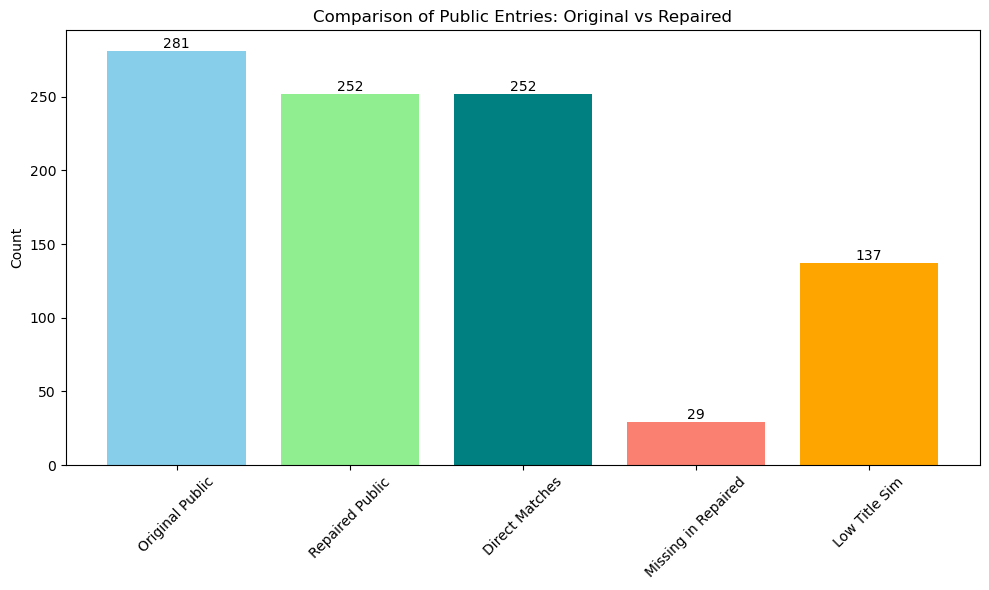

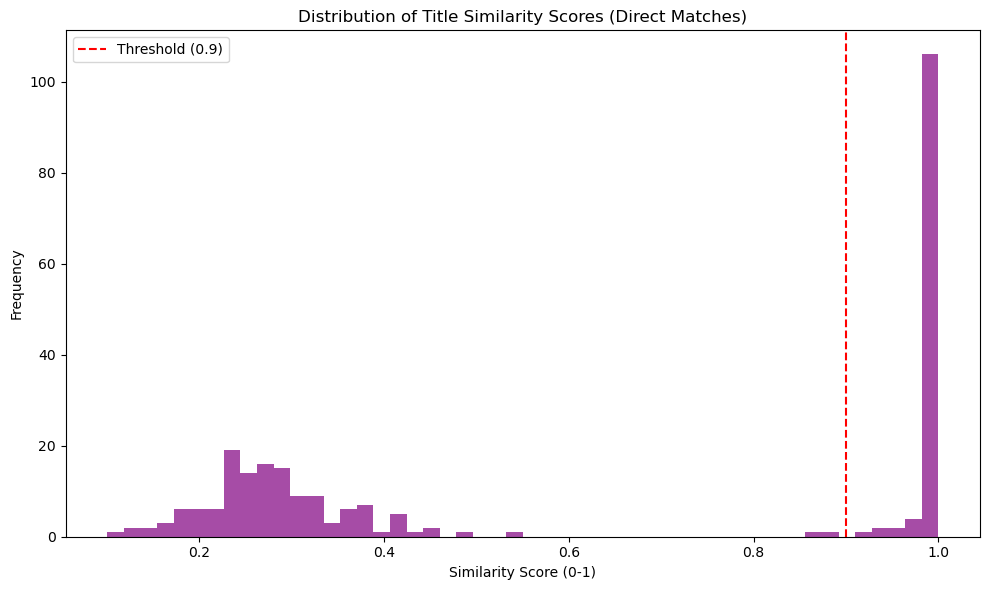

In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

# File paths
original_json_path = 'dome_review_raw_human_20260204.json'
repaired_json_path = 'v33_Dome-Recommendations-With_Provenance_reformatted.json'

# Helper function to load and filter
def load_and_filter_public(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    # Filter for public=True (assuming 'public' key exists and is boolean)
    public_entries = [entry for entry in data if entry.get('public') == True]
    return public_entries

# Load data
print(f"Loading {original_json_path}...")
original_data = load_and_filter_public(original_json_path)
print(f"Loaded {len(original_data)} public entries from original.")

print(f"Loading {repaired_json_path}...")
repaired_data = load_and_filter_public(repaired_json_path)
print(f"Loaded {len(repaired_data)} public entries from repaired.")

# Create dictionaries for easier lookup by shortid
# We use shortid as the primary key
orig_dict = {entry.get('shortid'): entry for entry in original_data if entry.get('shortid')}
rep_dict = {entry.get('shortid'): entry for entry in repaired_data if entry.get('shortid')}

# 1. Missing shortids
orig_ids = set(orig_dict.keys())
rep_ids = set(rep_dict.keys())

missing_in_repaired = orig_ids - rep_ids
common_ids = orig_ids.intersection(rep_ids)

print(f"\nAnalysis Results:")
print(f"Unique shortids in Original: {len(orig_ids)}")
print(f"Unique shortids in Repaired: {len(rep_ids)}")
print(f"Missing shortids in Repaired (present in Original): {len(missing_in_repaired)}")
print(f"Direct Match shortids: {len(common_ids)}")

# Save missing shortids to TSV
if missing_in_repaired:
    missing_data = []
    for sid in missing_in_repaired:
        entry = orig_dict[sid]
        missing_data.append({
            'shortid': sid,
            'title': entry.get('publication', {}).get('title', ''),
            'pmid': entry.get('publication', {}).get('pmid', '')
        })
    missing_df = pd.DataFrame(missing_data)
    missing_outfile = 'analysis_missing_shortids_in_repaired.tsv'
    missing_df.to_csv(missing_outfile, sep='\t', index=False)
    print(f"Saved missing shortids to {missing_outfile}")
else:
    print("No missing shortids found.")

# 2. Title Similarity Analysis for Direct Matches
low_similarity_threshold = 0.9 # Define threshold for "low"
low_sim_data = []
similarity_scores = []

for sid in common_ids:
    orig_entry = orig_dict[sid]
    rep_entry = rep_dict[sid]
    
    title_orig = orig_entry.get('publication', {}).get('title', '') or ''
    title_rep = rep_entry.get('publication', {}).get('title', '') or ''
    
    # Simple normalization (lower case, strip)
    t1 = str(title_orig).lower().strip()
    t2 = str(title_rep).lower().strip()
    
    ratio = SequenceMatcher(None, t1, t2).ratio()
    similarity_scores.append(ratio)
    
    if ratio < low_similarity_threshold:
        low_sim_data.append({
            'shortid': sid,
            'original_title': title_orig,
            'repaired_title': title_rep,
            'similarity_score': ratio
        })

print(f"Matches with Low Title Similarity (<{low_similarity_threshold}): {len(low_sim_data)}")

# Save low similarity matches to TSV
if low_sim_data:
    low_sim_df = pd.DataFrame(low_sim_data)
    low_sim_outfile = 'analysis_low_title_similarity_matches.tsv'
    low_sim_df.sort_values('similarity_score', inplace=True)
    low_sim_df.to_csv(low_sim_outfile, sep='\t', index=False)
    print(f"Saved low similarity report to {low_sim_outfile}")

# 3. Graphing
# Bar chart for counts
metrics = ['Original Public', 'Repaired Public', 'Direct Matches', 'Missing in Repaired', 'Low Title Sim']
counts = [len(orig_ids), len(rep_ids), len(common_ids), len(missing_in_repaired), len(low_sim_data)]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, counts, color=['skyblue', 'lightgreen', 'teal', 'salmon', 'orange'])
plt.title('Comparison of Public Entries: Original vs Repaired')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')

plt.tight_layout()
plt.savefig('analysis_comparison_chart.png')
plt.show()

# Histogram of similarity scores
if similarity_scores:
    plt.figure(figsize=(10, 6))
    plt.hist(similarity_scores, bins=50, color='purple', alpha=0.7)
    plt.title('Distribution of Title Similarity Scores (Direct Matches)')
    plt.xlabel('Similarity Score (0-1)')
    plt.ylabel('Frequency')
    plt.axvline(x=low_similarity_threshold, color='r', linestyle='--', label=f'Threshold ({low_similarity_threshold})')
    plt.legend()
    plt.tight_layout()
    plt.savefig('analysis_title_similarity_hist.png')
    plt.show()


In [6]:
# Load User Data to Filter by Curator
users_file_path = 'dome_users_20260202.json'
repaired_json_path = 'v33_Dome-Recommendations-With_Provenance_reformatted.json'
output_v34_path = 'altv34_Dome-Recommendations-Filtered.json'

# Names to exclude (partial match or based on email/name fields in user json)
# Based on request: Patrick Ruch, Federico Zambelli, Martina
excluded_names_keywords = ['patrick', 'ruch', 'federico', 'zambelli', 'martina']

print(f"Loading users from {users_file_path}...")
with open(users_file_path, 'r') as f:
    users_data = json.load(f)

# Identify User IDs to exclude
excluded_user_ids = set()
formatted_users = {} # Map OID to Name for debugging

for user in users_data:
    # Assuming standard structure with _id and name/email
    # Adjust field names based on actual JSON structure inspection if needed, 
    # but typically it's 'name', 'email', 'username'
    
    uid = user.get('_id', {}).get('$oid')
    if not uid: continue
    
    # Check identifying fields
    # Concatenate likely fields to search keywords
    user_str = (
        str(user.get('name', '')) + " " + 
        str(user.get('email', '')) + " " + 
        str(user.get('username', ''))
    ).lower()
    
    formatted_users[uid] = user_str
    
    # Check if any keyword matches
    # Note: "Martina" is a single name, others are full names. 
    # Checking if *any* part of the name matches might be too aggressive if "Martina" is common. 
    # But based on the specific request, we'll flag them.
    
    # Logic: If name contains "Patrick" AND "Ruch" OR "Federico" AND "Zambelli" OR "Martina"
    
    is_excluded = False
    if 'patrick' in user_str and 'ruch' in user_str:
        is_excluded = True
    elif 'federico' in user_str and 'zambelli' in user_str:
        is_excluded = True
    elif 'martina' in user_str:
        is_excluded = True
        
    if is_excluded:
        excluded_user_ids.add(uid)
        print(f"Excluding user: {user.get('name', 'Unknown')} ({user.get('email', '')}) - ID: {uid}")

print(f"\nTotal users found: {len(users_data)}")
print(f"Users to exclude: {len(excluded_user_ids)}")

# Load the Repaired JSON
print(f"\nLoading data from {repaired_json_path}...")
with open(repaired_json_path, 'r') as f:
    repaired_data = json.load(f)

original_count = len(repaired_data)
filtered_data = []

# Filter entries
for entry in repaired_data:
    # Get entry user ID
    entry_user_oid = entry.get('user', {}).get('$oid')
    
    if entry_user_oid in excluded_user_ids:
        continue # Skip this entry
    
    filtered_data.append(entry)

final_count = len(filtered_data)
removed_count = original_count - final_count

print(f"\nFiltering Complete:")
print(f"Original Entry Count: {original_count}")
print(f"Entries Removed: {removed_count}")
print(f"Final Entry Count: {final_count}")

# Save filtered JSON
with open(output_v34_path, 'w') as f:
    json.dump(filtered_data, f, indent=4)

print(f"Saved filtered dataset to {output_v34_path}")


Loading users from dome_users_20260202.json...
Excluding user: Unknown (martina.bevilacqua1991@gmail.com) - ID: 6312169df3794236aa9879df
Excluding user: Unknown (federico.zambelli@unimi.it) - ID: 6312169df3794236aa9879f6
Excluding user: Martina (martina.bevilacqua1992@gmail.com) - ID: 6312169df3794236aa987a03
Excluding user: Unknown (federico.zambelli@gmail.com) - ID: 6312169df3794236aa987a0c
Excluding user: Unknown (patrick.ruch@hesge.ch) - ID: 6312169df3794236aa987a36
Excluding user: Federico Zambelli () - ID: 65fc10d492c76639b83175d9

Total users found: 190
Users to exclude: 6

Loading data from v33_Dome-Recommendations-With_Provenance_reformatted.json...

Filtering Complete:
Original Entry Count: 258
Entries Removed: 28
Final Entry Count: 230
Saved filtered dataset to altv34_Dome-Recommendations-Filtered.json
